# 项目5-自编码器扩展

## 友情提示

同学们可以前往课程作业区先行动手尝试！！！

## 项目描述

这是**图像聚类**的教程。

目标：分辨给定的两张 images 是否为风景
* 如果直接在原本的 image 上做 cluster，结果会很差（有很多冗余资讯），因此需要更好的方式来表示原本的 image
* 为了找出这个更好的方式，可以先将原始 image 做 dimension reduction，用比较少的维度来描述一张 image
e.g., autoencoder, PCA, SVD, t-SNE.

1. 如果你想跳过**训练**阶段，请直接参考**聚类**部分。
1. **训练**所需部分：准备训练数据、模型、训练 
1. **聚类**所需部分：准备训练数据、模型、维度还原和聚类。

## 数据集介绍

> trainX.npy
* 里面总共有 8500 张 RGB 图片，大小都是 32*32*3
* shape 为 (8500, 32, 32, 3)

> valX.npy
* 里面总共有 500 张 RGB 图片，大小都是 32*32*3
* shape 为 (500, 32, 32, 3)

> valY.npy
* 对应 valX.npy 的 label
* shape为 (500,)

## 项目要求

1. 请使用 autoencoder 将 8500 张图片降维。再利用降维过的 latent code 做分类。最后预测 8500 笔测资是否来自相同的 dataset
1. 在 autoencoder 的训练过程中，至少挑选 10 个 checkpoints。请用 model 的 reconstruction error (用所有的 trainX 计算 MSE) 和 val accuracy 对那些 checkpoints 作图。

## 数据准备

无

## 环境配置/安装

无

# 准备训练数据

作业的第一部分是要训练一个autoencoder以抽取好的图片特征，第二部分则是将抽出来的特征降维到二维，以便我们利用分群的方法获得我们的答案   
定义我们的 preprocess：将图片的数值介于 0~255 的 int 线性转为 -1～1 的 float。

In [1]:
import numpy as np

def preprocess(image_list):
    """ Normalize Image and Permute (N,H,W,C) to (N,C,H,W)
    Args:
      image_list: List of images (9000, 32, 32, 3)
    Returns:
      image_list: List of images (9000, 3, 32, 32)
    """
    image_list = np.array(image_list)
    image_list = np.transpose(image_list, (0, 3, 1, 2))
    image_list = (image_list / 255.0) * 2 - 1
    image_list = image_list.astype(np.float32)
    return image_list

In [2]:
from paddle.io import Dataset

class Image_Dataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        images = self.image_list[idx]
        return images

将训练资料读入，并且 preprocess。 之后我们将 preprocess 完的训练资料变成我们需要的 dataset。请同学不要使用 valX 和 valY 来训练。

In [3]:
from paddle.io import DataLoader

trainX = np.load('work/trainX.npy')
trainX_preprocessed = preprocess(trainX)
img_dataset = Image_Dataset(trainX_preprocessed)

# 定义一些函数
这边提供一些有用的 functions。 一个是计算 model 参数量的（report 会用到），另一个是固定训练的随机种子（以便 reproduce）。

In [4]:
import random
import paddle

def count_parameters(model, only_trainable=False):
    if only_trainable:
        return sum(paddle.size(p) for p in model.parameters() if p.stop_gradient)
    else:
        return sum(paddle.size(p) for p in model.parameters())

def same_seeds(seed):
    paddle.seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.

# 搭建模型
定义我们的 baseline autoeocoder。

In [5]:
from paddle.nn import Sequential, Conv2D, ReLU, MaxPool2D, Conv2DTranspose, Tanh

class AE(paddle.nn.Layer):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = Sequential(
            Conv2D(3, 64, 3, stride=1, padding=1),
            ReLU(),
            MaxPool2D(2),
            Conv2D(64, 128, 3, stride=1, padding=1),
            ReLU(),
            MaxPool2D(2),
            Conv2D(128, 256, 3, stride=1, padding=1),
            ReLU(),
            MaxPool2D(2)
        )
 
        self.decoder = Sequential(
            Conv2DTranspose(256, 128, 5, stride=1),
            ReLU(),
            Conv2DTranspose(128, 64, 9, stride=1),
            ReLU(),
            Conv2DTranspose(64, 3, 17, stride=1),
            Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x  = self.decoder(x1)
        return x1, x

In [6]:
!nvidia-smi

Tue Dec  1 12:07:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   29C    P0    40W / 300W |     10MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 训练
这个部分就是主要的训练阶段。 我们先将准备好的 dataset 当作参数喂给 dataloader。 将 dataloader、model、loss criterion、optimizer 都准备好之后，就可以开始训练。 训练完成后，我们会将 model 存下来。

In [7]:
same_seeds(0)

model = AE()
criterion = paddle.nn.loss.MSELoss()
optimizer = paddle.optimizer.Adam(learning_rate=1e-5, parameters=model.parameters(), weight_decay=1e-5)

model.train()
n_epoch = 100

# 准备 dataloader, model, loss criterion 和 optimizer
img_dataloader = DataLoader(img_dataset, batch_size=64, shuffle=True)

epoch_loss = 0

# 主要的训练过程
for epoch in range(n_epoch):
    epoch_loss = 0
    for data in img_dataloader:
        img = data[0]

        output1, output = model(img)
        loss = criterion(output, img)
        
        optimizer.clear_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            paddle.save(model.state_dict(), 'work/checkpoints/model_checkpoint_{}.pdparams'.format(epoch+1))
            paddle.save(optimizer.state_dict(), 'work/checkpoints/optimizer_checkpoint_{}.pdopt'.format(epoch+1))
        epoch_loss += loss.numpy()[0]
            
    print('epoch [{}/{}], loss:{:.5f}'.format(epoch+1, n_epoch, epoch_loss))

# 训练完成后存储 model
paddle.save(model.state_dict(), 'work/checkpoints/last_model_checkpoint.pdparams')
paddle.save(optimizer.state_dict(), 'work/checkpoints/last_optimizer_checkpoint.pdopt')

epoch [1/100], loss:30.19154
epoch [2/100], loss:25.08458
epoch [3/100], loss:20.90796
epoch [4/100], loss:17.80143
epoch [5/100], loss:15.94472
epoch [6/100], loss:14.77850
epoch [7/100], loss:13.95923
epoch [8/100], loss:13.35432
epoch [9/100], loss:12.87183
epoch [10/100], loss:12.48734
epoch [11/100], loss:12.14320
epoch [12/100], loss:11.83311
epoch [13/100], loss:11.56657
epoch [14/100], loss:11.33461
epoch [15/100], loss:11.12911
epoch [16/100], loss:10.94506
epoch [17/100], loss:10.76948
epoch [18/100], loss:10.61642
epoch [19/100], loss:10.46068
epoch [20/100], loss:10.32188
epoch [21/100], loss:10.18671
epoch [22/100], loss:10.05331
epoch [23/100], loss:9.92232
epoch [24/100], loss:9.81101
epoch [25/100], loss:9.68999
epoch [26/100], loss:9.57853
epoch [27/100], loss:9.47256
epoch [28/100], loss:9.36383
epoch [29/100], loss:9.26560
epoch [30/100], loss:9.17621
epoch [31/100], loss:9.07503
epoch [32/100], loss:8.98799
epoch [33/100], loss:8.90127
epoch [34/100], loss:8.80939
e

# 降维和聚类

In [8]:
import numpy as np

def cal_acc(gt, pred):
    """ Computes categorization accuracy of our task.
    Args:
      gt: Ground truth labels (9000, )
      pred: Predicted labels (9000, )
    Returns:
      acc: Accuracy (0~1 scalar)
    """
    # Calculate Correct predictions
    correct = np.sum(gt == pred)
    acc = correct / gt.shape[0]
    # 因为是 binary unsupervised clustering，因此取 max(acc, 1-acc)
    return max(acc, 1-acc)

In [9]:
import matplotlib.pyplot as plt

def plot_scatter(feat, label, savefig=None):
    """ Plot Scatter Image.
    Args:
      feat: the (x, y) coordinate of clustering result, shape: (9000, 2)
      label: ground truth label of image (0/1), shape: (9000,)
    Returns:
      None
    """
    X = feat[:, 0]
    Y = feat[:, 1]
    plt.scatter(X, Y, c = label)
    plt.legend(loc='best')
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


接著我们使用训练好的 model，来预测 testing data 的类别。   
由于 testing data 与 training data 一样，因此我们使用同样的 dataset 来实作 dataloader。与 training 不同的地方在于 shuffle 这个参数值在这边是 False。   
准备好 model 与 dataloader，我们就可以进行预测了。   
我们只需要 encoder 的结果（latents），利用 latents 进行 clustering 之后，就可以分类了。

In [10]:
import paddle
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

def inference(X, model, batch_size=256):
    X = preprocess(X)
    dataset = Image_Dataset(X)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    latents = []
    for i, x in enumerate(dataloader):
        
        vec, img = model(x[0])
        if i == 0:
            latents = paddle.reshape(vec, [img.shape[0], -1]).numpy()
        else:
            latents = np.concatenate((latents, paddle.reshape(vec, [img.shape[0], -1]).numpy()), axis = 0)

    print('Latents Shape:', latents.shape)
    return latents

def predict(latents):
    # First Dimension Reduction
    transformer = KernelPCA(n_components=200, kernel='rbf', n_jobs=-1)
    kpca = transformer.fit_transform(latents)
    print('First Reduction Shape:', kpca.shape)

    # # Second Dimesnion Reduction
    X_embedded = TSNE(n_components=2).fit_transform(kpca)
    print('Second Reduction Shape:', X_embedded.shape)

    # Clustering
    pred = MiniBatchKMeans(n_clusters=2, random_state=0).fit(X_embedded)
    pred = [int(i) for i in pred.labels_]
    pred = np.array(pred)
    return pred, X_embedded

def invert(pred):
    return np.abs(1-pred)

def save_prediction(pred, out_csv='work/prediction.csv'):
    with open(out_csv, 'w') as f:
        f.write('id,label\n')
        for i, p in enumerate(pred):
            f.write(f'{i},{p}\n')
    print(f'Save prediction to {out_csv}.')

# load model
model = AE()

layer_state_dict = paddle.load('work/checkpoints/last_model_checkpoint.pdparams')
model.set_state_dict(layer_state_dict)

model.eval()

# 准备 data
trainX = np.load('work/trainX.npy')

# 预测答案
latents = inference(X=trainX, model=model)
pred, X_embedded = predict(latents)

# 将预测结果存档
save_prediction(pred, 'work/prediction.csv')
save_prediction(invert(pred), 'work/prediction_invert.csv')

Latents Shape: (8500, 4096)
First Reduction Shape: (8500, 200)
Second Reduction Shape: (8500, 2)
Save prediction to work/prediction.csv.
Save prediction to work/prediction_invert.csv.


# Problem 1.b  (作图)
将 val data 的降维结果 (embedding) 与他们对应的 label 画出来。

Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
No handles with labels found to put in legend.


Second Reduction Shape: (500, 2)
The clustering accuracy is: 0.708
The clustering result:


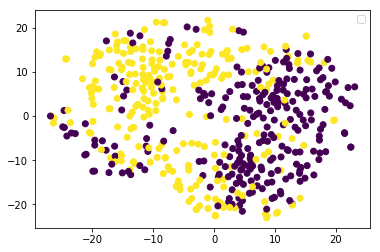

In [11]:
valX = np.load('work/valX.npy')
valY = np.load('work/valY.npy')

# ==============================================
#  我们示范 basline model 的作图，
#  report 请同学另外还要再画一张 improved model 的图。
# ==============================================
model.set_state_dict(paddle.load('work/checkpoints/last_model_checkpoint.pdparams'))
model.eval()
latents = inference(valX, model)
pred_from_latent, emb_from_latent = predict(latents)
acc_latent = cal_acc(valY, pred_from_latent)
print('The clustering accuracy is:', acc_latent)
print('The clustering result:')
plot_scatter(emb_from_latent, valY, savefig='work/p1_baseline.png')

# Problem 2
使用你 test accuracy 最高的 autoencoder，从 trainX 中，取出 index 1, 2, 3, 6, 7, 9 这 6 张图片，画出他们的原图以及 reconstruct 之后的图片。

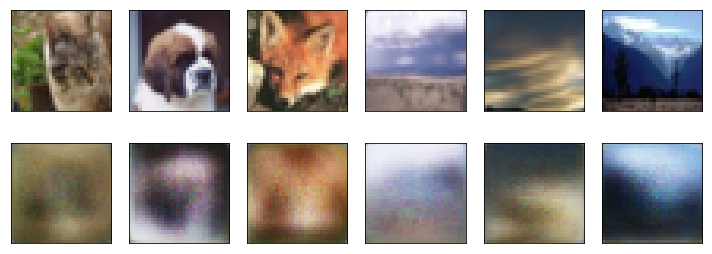

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 画出原图
plt.figure(figsize=(10,4))
indexes = [1,2,3,6,7,9]
imgs = trainX[indexes,]
for i, img in enumerate(imgs):
    plt.subplot(2, 6, i+1, xticks=[], yticks=[])
    plt.imshow(img)

# 画出 reconstruct 的图
inp = paddle.Tensor(trainX_preprocessed[indexes,])
latents, recs = model(inp)
recs = ((recs+1)/2 ).numpy()

recs = recs.transpose(0, 2, 3, 1)
for i, img in enumerate(recs):
    plt.subplot(2, 6, 6+i+1, xticks=[], yticks=[])
    plt.imshow(img)
  
plt.tight_layout()

# Problem 3
在 autoencoder 的训练过程中，至少挑选 10 个 checkpoints 请用 model 的 train reconstruction error 对 val accuracy 作图 简单说明你观察到的现象

In [13]:
import glob
checkpoints_list = sorted(glob.glob('work/checkpoints/model_checkpoint_*.pdparams'))

# load data
dataset = Image_Dataset(trainX_preprocessed)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

points = []

for i, checkpoint in enumerate(checkpoints_list):
    print('[{}/{}] {}'.format(i+1, len(checkpoints_list), checkpoint))
    model.set_state_dict(paddle.load(checkpoint))
    model.eval()
    err = 0
    n = 0
    for x in dataloader:
        _, rec = model(x[0])
        err += paddle.nn.loss.MSELoss(reduction='sum')(x[0], rec).numpy()
        n += x[0].flatten().shape[0]
    print('Reconstruction error (MSE):', err/n)
    latents = inference(X=valX, model=model)
    pred, X_embedded = predict(latents)
    acc = cal_acc(valY, pred)
    print('Accuracy:', acc)
    points.append((err/n, acc))

[1/10] work/checkpoints/model_checkpoint_10.pdparams
Reconstruction error (MSE): [0.092254]
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.536
[2/10] work/checkpoints/model_checkpoint_100.pdparams
Reconstruction error (MSE): [0.04644353]
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.704
[3/10] work/checkpoints/model_checkpoint_20.pdparams
Reconstruction error (MSE): [0.07696287]
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.614
[4/10] work/checkpoints/model_checkpoint_30.pdparams
Reconstruction error (MSE): [0.06847264]
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.644
[5/10] work/checkpoints/model_checkpoint_40.pdparams
Reconstruction error (MSE): [0.06265614]
Latents Shape: (500, 4096)
First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 

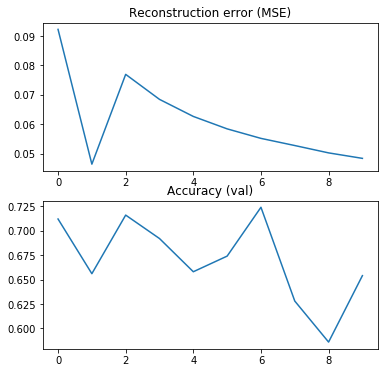

In [37]:
ps = list(zip(*points))
plt.figure(figsize=(6,6))
plt.subplot(211, title='Reconstruction error (MSE)').plot(ps[0])
plt.subplot(212, title='Accuracy (val)').plot(ps[1])
plt.show()